https://webnautes.tistory.com/1410

In [90]:
import dlib
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import copy
import math

import torch
import torchvision
from torchvision import models
import torchvision.transforms as T
from PIL import Image

In [84]:
Detector = dlib.get_frontal_face_detector()
Predictor = dlib.shape_predictor(r'E:\GithubProjects\KagglePractice\HelmetDetection\models\shape_predictor_68_face_landmarks.dat')

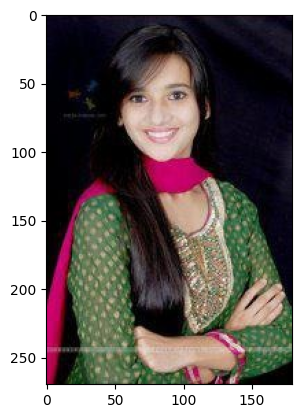

In [86]:
img = cv.imread(r'E:\GithubProjects\KagglePractice\HelmetDetection\RawDatasets\without_helmet\0.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

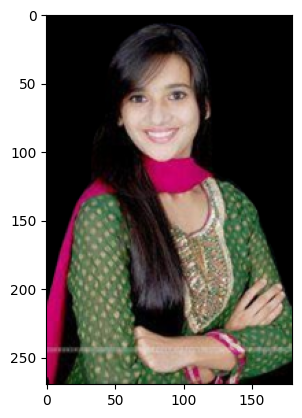

In [92]:
ColorArray = np.array([
	(0, 0, 0),       # 0=background
	(0, 0, 0),       # 1=aeroplane
	(0, 0, 0),       # 2=bicycle
	(0, 0, 0),       # 3=bird
	(0, 0, 0),       # 4=boat
	(0, 0, 0),       # 5=bottle
	(0, 0, 0),       # 6=bus
	(0, 0, 0),       # 7=car
	(0, 0, 0),       # 8=cat
	(0, 0, 0),       # 9=chair
	(0, 0, 0),       # 10=cow
	(0, 0, 0),       # 11=dining table
	(0, 0, 0),       # 12=dog
	(0, 0, 0),       # 13=horse
	(0, 0, 0),       # 14=motorbike
	(255, 255, 255), # 15=person
	(0, 0, 0),       # 16=potted plant
	(0, 0, 0),       # 17=sheep
	(0, 0, 0),       # 18=sofa
	(0, 0, 0),       # 19=train
	(0, 0, 0),       # 20=tv/monitor
])

def seg_map(img, n_classes=21):
	global ColorArray

	rgb = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

	for c in range(n_classes):
		idx = img == c

		rgb[idx] = ColorArray[c]

	return rgb

IMG_SIZE = 480

deeplab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
Height, Width = cv.imread(r'E:\GithubProjects\KagglePractice\HelmetDetection\RawDatasets\without_helmet\0.jpg').shape[:2]
img = Image.open(r'E:\GithubProjects\KagglePractice\HelmetDetection\RawDatasets\without_helmet\0.jpg').resize((600, 450))

trf = T.Compose([
	T.Resize(IMG_SIZE),
	T.ToTensor(),
	T.Normalize(
		mean=[0.485, 0.456, 0.406],
		std=[0.229, 0.224, 0.225]
	)
])

input_img = trf(img).unsqueeze(0)

out = deeplab(input_img)['out']

out = torch.argmax(out.squeeze(), dim=0)
out = out.detach().cpu().numpy()

out_seg = seg_map(out)
ClearImage = Image.fromarray(img.resize((640, 480)) & out_seg).resize((Width,Height))
plt.imshow(ClearImage)

In [4]:
ALL = list(range(0, 68)) 
RIGHT_EYEBROW = list(range(17, 22))  
LEFT_EYEBROW = list(range(22, 27))  
RIGHT_EYE = list(range(36, 42))  
LEFT_EYE = list(range(42, 48))  
NOSE = list(range(27, 36))  
MOUTH_OUTLINE = list(range(48, 61))  
MOUTH_INNER = list(range(61, 68)) 
JAWLINE = list(range(0, 17)) 

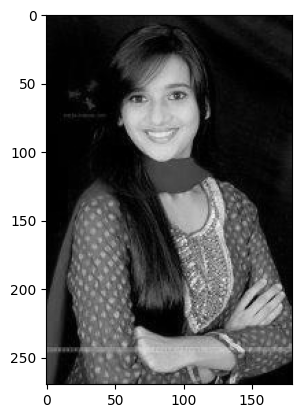

In [5]:
GrayImage = cv.cvtColor(ClearImage, cv.COLOR_RGB2GRAY)
plt.imshow(cv.cvtColor(GrayImage, cv.COLOR_BGR2RGB))

In [6]:
dets = Detector(GrayImage)
dets

rectangles[[(45, 45) (117, 117)]]

(95, 60) (67, 62)


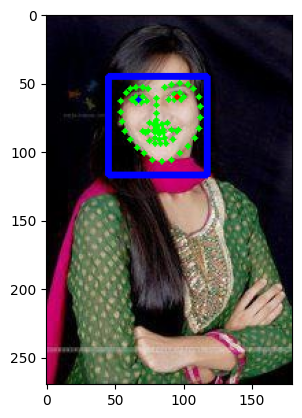

In [7]:
index = ALL

ShowImage = copy.deepcopy(img)

face = dets[0]


shape = Predictor(ShowImage, face)

list_points = []
for p in shape.parts():
	list_points.append([p.x, p.y])
list_points = np.array(list_points)

for i,pt in enumerate(list_points[index]):

	pt_pos = (pt[0], pt[1])
	cv.circle(ShowImage, pt_pos, 2, (0, 255, 0), -1)

RightEyePosList = []
for i, pt in enumerate(list_points[RIGHT_EYE]):
	RightEyePosList.append((pt[0], pt[1]))

LeftEyePosList = []
for i, pt in enumerate(list_points[LEFT_EYE]):
	LeftEyePosList.append((pt[0], pt[1]))

LeftEyeCenter = (int(sum(map(lambda x : x[0], RightEyePosList)) / len(RightEyePosList)),
					int(sum(map(lambda x : x[1], RightEyePosList)) / len(RightEyePosList)))

RightEyeCenter = (int(sum(map(lambda x : x[0], LeftEyePosList)) / len(LeftEyePosList)),
					int(sum(map(lambda x : x[1], LeftEyePosList)) / len(LeftEyePosList)))
print(RightEyeCenter, LeftEyeCenter)
cv.circle(ShowImage, RightEyeCenter, 2, (255, 0, 0), -1)
cv.circle(ShowImage, LeftEyeCenter, 2, (0, 0, 255), -1)

cv.rectangle(ShowImage, (face.left(), face.top()), (face.right(), face.bottom()),
	(0, 0, 255), 3)
plt.imshow(ShowImage)

In [8]:
def Rotate(ResultImage, angle):
	ResultImage = copy.deepcopy(ResultImage)
	image_center = tuple(np.array(ResultImage.shape[1::-1]) / 2)
	rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
	ResultImage = cv.warpAffine(ResultImage, rot_mat, ResultImage.shape[1::-1], flags=cv.INTER_LINEAR)
	return ResultImage

In [9]:
EyeWidth, EyeHeight = RightEyeCenter[0] - LeftEyeCenter[0], RightEyeCenter[1] - LeftEyeCenter[1]
EyeWidth, EyeHeight

(28, -2)

In [10]:
Radian = math.atan2(EyeHeight, EyeWidth)
Angle = Radian * 180 / math.pi
Angle

-4.085616779974877

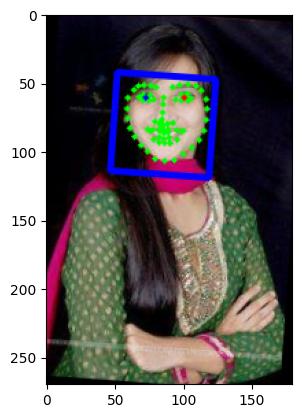

In [11]:
plt.imshow(Rotate(ShowImage, Angle))

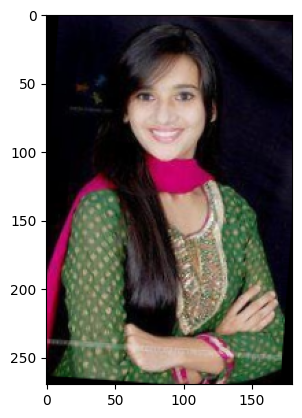

In [12]:
plt.imshow(Rotate(img, Angle))

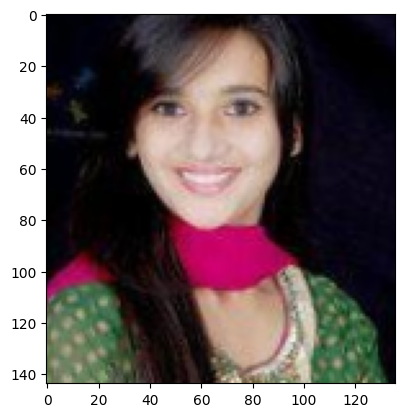

In [13]:
def ChangeToAvailable(value : int, maxValue : int):
	return 0 if value < 0 else maxValue if value > maxValue else value

FaceWidth = int(face.width())
WidthSlash2 = int(face.width() / 2)
x0,y0 = face.left() - FaceWidth, face.top() - FaceWidth
x1,y1 = face.right() + FaceWidth, face.bottom() + FaceWidth
ImageHeight, ImageWidth = img.shape[:2]
x0,y0,x1,y1 = ChangeToAvailable(x0,ImageWidth),ChangeToAvailable(y0,ImageHeight),ChangeToAvailable(x1,ImageWidth),ChangeToAvailable(y1,ImageHeight)
RotatedImage = Rotate(img[y0:y1,x0:x1], Angle)

ImageHeight, ImageWidth = RotatedImage.shape[:2]
PaddingValueX = int(ImageWidth/8)
PaddingValueY = int(ImageHeight/8)
x0,y0,x1,y1=PaddingValueX,PaddingValueY,ImageWidth - PaddingValueX,ImageHeight - PaddingValueY
RotatedImage = RotatedImage[y0:y1,x0:x1]
plt.imshow(RotatedImage)

array([0, 0, 0], dtype=uint8)

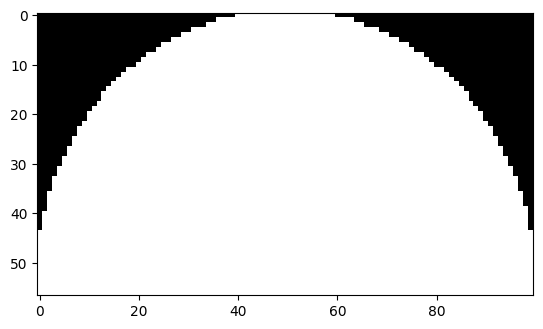

In [14]:
HelmetImage = cv.imread(r'E:\GithubProjects\KagglePractice\HelmetDetection\HelmetImage.png', -1)
HelmetImage = cv.cvtColor(HelmetImage, cv.COLOR_BGR2RGB)
plt.imshow(HelmetImage)
HelmetImage[0][0]

In [15]:
from PIL import Image

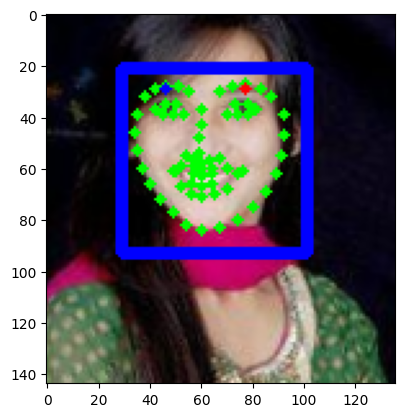

In [69]:
index = ALL

ShowImage = copy.deepcopy(RotatedImage)

GrayImage = cv.cvtColor(ShowImage, cv.COLOR_RGB2GRAY)
dets = Detector(GrayImage)
face = dets[0]

shape = Predictor(ShowImage, face)

list_points = []
for p in shape.parts():
	list_points.append([p.x, p.y])
list_points = np.array(list_points)

for i,pt in enumerate(list_points[index]):

	pt_pos = (pt[0], pt[1])
	cv.circle(ShowImage, pt_pos, 2, (0, 255, 0), -1)

RightEyeBrowPosList = []
for i, pt in enumerate(list_points[RIGHT_EYEBROW]):
	RightEyeBrowPosList.append((pt[0], pt[1]))

LeftEyeBrowPosList = []
for i, pt in enumerate(list_points[LEFT_EYEBROW]):
	LeftEyeBrowPosList.append((pt[0], pt[1]))

LeftEyeBrowCenter = (int(sum(map(lambda x : x[0], RightEyeBrowPosList)) / len(RightEyeBrowPosList)),
					int(sum(map(lambda x : x[1], RightEyeBrowPosList)) / len(RightEyeBrowPosList)))

RightEyeBrowCenter = (int(sum(map(lambda x : x[0], LeftEyeBrowPosList)) / len(LeftEyeBrowPosList)),
					int(sum(map(lambda x : x[1], LeftEyeBrowPosList)) / len(LeftEyeBrowPosList)))

cv.circle(ShowImage, RightEyeBrowCenter, 2, (255, 0, 0), -1)
cv.circle(ShowImage, LeftEyeBrowCenter, 2, (0, 0, 255), -1)

cv.rectangle(ShowImage, (face.left(), face.top()), (face.right(), face.bottom()),
	(0, 0, 255), 3)
plt.imshow(ShowImage)

(44, 77, 3)


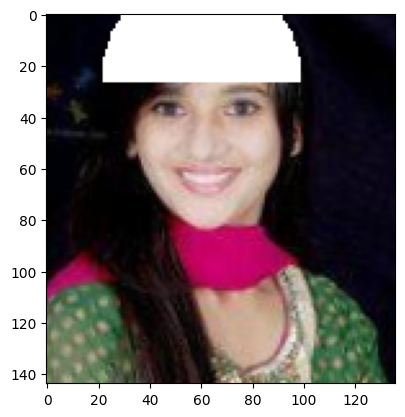

In [82]:
AddedImage = copy.deepcopy(RotatedImage)
HelmetWidth = RightEyeBrowCenter[0] - LeftEyeBrowCenter[0]
# Width : Height = HelmetWidth : ?
# ? = HelmetWidth * HEight / Width
# 100 x 57
# ? = HelmetWidth * 57 / 100
HelmetImageCopy = cv.resize(copy.deepcopy(HelmetImage), (int(HelmetWidth * 2.5), int(HelmetWidth * 0.57 * 2.5)))
plt.imshow(HelmetImageCopy)
print(HelmetImageCopy.shape)
x_offset = int((RightEyeBrowCenter[0] + LeftEyeBrowCenter[0])/2 - HelmetWidth * 1.25)
y_offset = int((RightEyeBrowCenter[1] + LeftEyeBrowCenter[1])/2 - HelmetWidth * 1.5)
CheckArray = np.array([0, 0, 0])
for y in range(HelmetImageCopy.shape[0]):
	for x in range(HelmetImageCopy.shape[1]):
		try:
			if y_offset+y < 0 or x_offset+x < 0:
				continue
			if HelmetImageCopy[y][x][0] == 255:
				AddedImage[y_offset+y,x_offset+x] = HelmetImageCopy[y][x]
			# else:
			# 	AddedImage[y_offset+y,x_offset+x] = np.array([255, 0, 0])
		except:
			pass
plt.imshow(AddedImage)